# Goodluck!

# Mid-semester assignment - reinforcements learning 
Hello dear students,<br> this is the template notebook. Please click on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1 Name: Or Livne, ID: 203972922
<br>
Student 2:Name: Oz Sharlin , ID: 200705754

## Installs

In [1]:
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for gym: filename=gym-0.23.1-py3-none-any.whl size=701376 sha256=a46c05498382a69ed4452f7b9adc5ecebe03ea9086f67dedcd248af42025627f
  Stored in directory: c:\users\orlivne\appdata\local\pip\cache\wheels\4e\be\7e\92a54668db96883e38ce60a9249dc55de7cd6eee49e7311940
Successfully built gym
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.8.1
    Uninstalling importlib-metadata-4.8.1:
      Successfully uninstalled importlib-metadata-4.8.1


'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt' is not recognized as an internal or external command,
operable program or batch file.


## Imports

In [2]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame

ImportError: cannot import name 'Monitor' from 'gym.wrappers' (C:\Users\orlivne\anaconda3\lib\site-packages\gym\wrappers\__init__.py)

## Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()



if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1



"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## MazeEnv
The cell below contains the configuration of the maze environment. No need to make changes here.

In [ ]:

class MazeEnv(gym.Env):
    metadata = {
        "render.modes": ["human", "rgb_array"],
    }

    ACTION = ["N", "S", "E", "W"]

    def __init__(self, maze_file=None, maze_size=None, mode=None, enable_render=True):

        self.viewer = None
        self.enable_render = enable_render

        if maze_file:
            self.maze_view = MazeView2D(maze_name="OpenAI Gym - Maze (%s)" % maze_file,
                                        maze_file_path=maze_file,
                                        screen_size=(640, 640), 
                                        enable_render=enable_render)
        elif maze_size:
            if mode == "plus":
                has_loops = True
                num_portals = int(round(min(maze_size)/3))
            else:
                has_loops = False
                num_portals = 0

            self.maze_view = MazeView2D(maze_name="OpenAI Gym - Maze (%d x %d)" % maze_size,
                                        maze_size=maze_size, screen_size=(640, 640),
                                        has_loops=has_loops, num_portals=num_portals,
                                        enable_render=enable_render)
        else:
            raise AttributeError("One must supply either a maze_file path (str) or the maze_size (tuple of length 2)")

        self.maze_size = self.maze_view.maze_size

        # forward or backward in each dimension
        self.action_space = spaces.Discrete(2*len(self.maze_size))

        # observation is the x, y coordinate of the grid
        low = np.zeros(len(self.maze_size), dtype=int)
        high =  np.array(self.maze_size, dtype=int) - np.ones(len(self.maze_size), dtype=int)
        self.observation_space = spaces.Box(low, high, dtype=np.int64)

        # initial condition
        self.state = None
        self.steps_beyond_done = None

        # Simulation related variables.
        self.seed()
        self.reset()

        # Just need to initialize the relevant attributes
        self.configure()

    def __del__(self):
        if self.enable_render is True:
            self.maze_view.quit_game()

    def configure(self, display=None):
        self.display = display

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        if isinstance(action, int):

            self.maze_view.move_robot(self.ACTION[action])
        else:
            self.maze_view.move_robot(action)

        if np.array_equal(self.maze_view.robot, self.maze_view.goal):
            reward = 1
            done = True
        else:
            reward = -0.1/(self.maze_size[0]*self.maze_size[1])
            done = False

        self.state = self.maze_view.robot

        info = {}

        return self.state, reward, done, info

    def reset(self):
        self.maze_view.reset_robot()
        self.state = np.zeros(2)
        self.steps_beyond_done = None
        self.done = False
        return self.state

    def is_game_over(self):
        return self.maze_view.game_over

    def render(self, mode="human", close=False):
        if close:
            self.maze_view.quit_game()

        return self.maze_view.update(mode)



class MazeView2D:

    def __init__(self, maze_name="Maze2D", maze_file_path=None,
                 maze_size=(30, 30), screen_size=(600, 600),
                 has_loops=False, num_portals=0, enable_render=True):

        # PyGame configurations
        pygame.init()
        pygame.display.set_caption(maze_name)
        self.clock = pygame.time.Clock()
        self.__game_over = False
        self.__enable_render = enable_render

        # Load a maze
        if maze_file_path is None:
            self.__maze = Maze(maze_size=maze_size, has_loops=has_loops, num_portals=num_portals)
        else:
            if not os.path.exists(maze_file_path):
                dir_path = os.path.dirname(os.path.abspath(__file__))
                rel_path = os.path.join(dir_path, "maze_samples", maze_file_path)
                if os.path.exists(rel_path):
                    maze_file_path = rel_path
                else:
                    raise FileExistsError("Cannot find %s." % maze_file_path)
            self.__maze = Maze(maze_cells=Maze.load_maze(maze_file_path))

        self.maze_size = self.__maze.maze_size
        if self.__enable_render is True:
            # to show the right and bottom border
            self.screen = pygame.display.set_mode(screen_size)
            self.__screen_size = tuple(map(sum, zip(screen_size, (-1, -1))))

        # Set the starting point
        self.__entrance = np.zeros(2, dtype=int)

        # Set the Goal
        self.__goal = np.array(self.maze_size) - np.array((1, 1))

        # Create the Robot
        self.__robot = self.entrance

        if self.__enable_render is True:
            # Create a background
            self.background = pygame.Surface(self.screen.get_size()).convert()
            self.background.fill((255, 255, 255))

            # Create a layer for the maze
            self.maze_layer = pygame.Surface(self.screen.get_size()).convert_alpha()
            self.maze_layer.fill((0, 0, 0, 0,))

            # show the maze
            self.__draw_maze()

            # show the portals
            self.__draw_portals()

            # show the robot
            self.__draw_robot()

            # show the entrance
            self.__draw_entrance()

            # show the goal
            self.__draw_goal()

    def update(self, mode="human"):
        try:
            img_output = self.__view_update(mode)
            self.__controller_update()
        except Exception as e:
            self.__game_over = True
            self.quit_game()
            raise e
        else:
            return img_output

    def quit_game(self):
        try:
            self.__game_over = True
            if self.__enable_render is True:
                pygame.display.quit()
            pygame.quit()
        except Exception:
            pass

    def move_robot(self, dir):
        if dir not in self.__maze.COMPASS.keys():
            raise ValueError("dir cannot be %s. The only valid dirs are %s."
                             % (str(dir), str(self.__maze.COMPASS.keys())))

        if self.__maze.is_open(self.__robot, dir):

            # update the drawing
            self.__draw_robot(transparency=0)

            # move the robot
            self.__robot += np.array(self.__maze.COMPASS[dir])
            # if it's in a portal afterward
            if self.maze.is_portal(self.robot):
                self.__robot = np.array(self.maze.get_portal(tuple(self.robot)).teleport(tuple(self.robot)))
            self.__draw_robot(transparency=255)

    def reset_robot(self):

        self.__draw_robot(transparency=0)
        self.__robot = np.zeros(2, dtype=int)
        self.__draw_robot(transparency=255)

    def __controller_update(self):
        if not self.__game_over:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    self.__game_over = True
                    self.quit_game()

    def __view_update(self, mode="human"):
        if not self.__game_over:
            # update the robot's position
            self.__draw_entrance()
            self.__draw_goal()
            self.__draw_portals()
            self.__draw_robot()


            # update the screen
            self.screen.blit(self.background, (0, 0))
            self.screen.blit(self.maze_layer,(0, 0))

            if mode == "human":
                pygame.display.flip()

            return np.flipud(np.rot90(pygame.surfarray.array3d(pygame.display.get_surface())))

    def __draw_maze(self):
        
        if self.__enable_render is False:
            return
        
        line_colour = (0, 0, 0, 255)

        # drawing the horizontal lines
        for y in range(self.maze.MAZE_H + 1):
            pygame.draw.line(self.maze_layer, line_colour, (0, y * self.CELL_H),
                             (self.SCREEN_W, y * self.CELL_H))

        # drawing the vertical lines
        for x in range(self.maze.MAZE_W + 1):
            pygame.draw.line(self.maze_layer, line_colour, (x * self.CELL_W, 0),
                             (x * self.CELL_W, self.SCREEN_H))

        # breaking the walls
        for x in range(len(self.maze.maze_cells)):
            for y in range (len(self.maze.maze_cells[x])):
                # check the which walls are open in each cell
                walls_status = self.maze.get_walls_status(self.maze.maze_cells[x, y])
                dirs = ""
                for dir, open in walls_status.items():
                    if open:
                        dirs += dir
                self.__cover_walls(x, y, dirs)

    def __cover_walls(self, x, y, dirs, colour=(0, 0, 255, 15)):

        if self.__enable_render is False:
            return
        
        dx = x * self.CELL_W
        dy = y * self.CELL_H

        if not isinstance(dirs, str):
            raise TypeError("dirs must be a str.")

        for dir in dirs:
            if dir == "S":
                line_head = (dx + 1, dy + self.CELL_H)
                line_tail = (dx + self.CELL_W - 1, dy + self.CELL_H)
            elif dir == "N":
                line_head = (dx + 1, dy)
                line_tail = (dx + self.CELL_W - 1, dy)
            elif dir == "W":
                line_head = (dx, dy + 1)
                line_tail = (dx, dy + self.CELL_H - 1)
            elif dir == "E":
                line_head = (dx + self.CELL_W, dy + 1)
                line_tail = (dx + self.CELL_W, dy + self.CELL_H - 1)
            else:
                raise ValueError("The only valid directions are (N, S, E, W).")

            pygame.draw.line(self.maze_layer, colour, line_head, line_tail)

    def __draw_robot(self, colour=(0, 0, 150), transparency=255):

        if self.__enable_render is False:
            return
        
        x = int(self.__robot[0] * self.CELL_W + self.CELL_W * 0.5 + 0.5)
        y = int(self.__robot[1] * self.CELL_H + self.CELL_H * 0.5 + 0.5)
        r = int(min(self.CELL_W, self.CELL_H)/5 + 0.5)

        pygame.draw.circle(self.maze_layer, colour + (transparency,), (x, y), r)

    def __draw_entrance(self, colour=(0, 0, 150), transparency=235):

        self.__colour_cell(self.entrance, colour=colour, transparency=transparency)

    def __draw_goal(self, colour=(150, 0, 0), transparency=235):

        self.__colour_cell(self.goal, colour=colour, transparency=transparency)

    def __draw_portals(self, transparency=160):

        if self.__enable_render is False:
            return
        
        colour_range = np.linspace(0, 255, len(self.maze.portals), dtype=int)
        colour_i = 0
        for portal in self.maze.portals:
            colour = ((100 - colour_range[colour_i])% 255, colour_range[colour_i], 0)
            colour_i += 1
            for location in portal.locations:
                self.__colour_cell(location, colour=colour, transparency=transparency)

    def __colour_cell(self, cell, colour, transparency):

        if self.__enable_render is False:
            return

        if not (isinstance(cell, (list, tuple, np.ndarray)) and len(cell) == 2):
            raise TypeError("cell must a be a tuple, list, or numpy array of size 2")

        x = int(cell[0] * self.CELL_W + 0.5 + 1)
        y = int(cell[1] * self.CELL_H + 0.5 + 1)
        w = int(self.CELL_W + 0.5 - 1)
        h = int(self.CELL_H + 0.5 - 1)
        pygame.draw.rect(self.maze_layer, colour + (transparency,), (x, y, w, h))

    @property
    def maze(self):
        return self.__maze

    @property
    def robot(self):
        return self.__robot

    @property
    def entrance(self):
        return self.__entrance

    @property
    def goal(self):
        return self.__goal

    @property
    def game_over(self):
        return self.__game_over

    @property
    def SCREEN_SIZE(self):
        return tuple(self.__screen_size)

    @property
    def SCREEN_W(self):
        return int(self.SCREEN_SIZE[0])

    @property
    def SCREEN_H(self):
        return int(self.SCREEN_SIZE[1])

    @property
    def CELL_W(self):
        return float(self.SCREEN_W) / float(self.maze.MAZE_W)

    @property
    def CELL_H(self):
        return float(self.SCREEN_H) / float(self.maze.MAZE_H)

class Maze:

    COMPASS = {
        "N": (0, -1),
        "E": (1, 0),
        "S": (0, 1),
        "W": (-1, 0)
    }

    def __init__(self, maze_cells=None, maze_size=(10,10), has_loops=True, num_portals=0):

        # maze member variables
        self.maze_cells = maze_cells
        self.has_loops = has_loops
        self.__portals_dict = dict()
        self.__portals = []
        self.num_portals = num_portals

        # Use existing one if exists
        if self.maze_cells is not None:
            if isinstance(self.maze_cells, (np.ndarray, np.generic)) and len(self.maze_cells.shape) == 2:
                self.maze_size = tuple(maze_cells.shape)
            else:
                raise ValueError("maze_cells must be a 2D NumPy array.")
        # Otherwise, generate a random one
        else:
            raise ValueError("Please upload the maze you downloaded in the submission box!")
         

    def save_maze(self, file_path):

        if not isinstance(file_path, str):
            raise TypeError("Invalid file_path. It must be a str.")

        if not os.path.exists(os.path.dirname(file_path)):
            raise ValueError("Cannot find the directory for %s." % file_path)

        else:
            np.save(file_path, self.maze_cells, allow_pickle=False, fix_imports=True)

    @classmethod
    def load_maze(cls, file_path):

        if not isinstance(file_path, str):
            raise TypeError("Invalid file_path. It must be a str.")

        if not os.path.exists(file_path):
            raise ValueError("Cannot find %s." % file_path)

        else:
            return np.load(file_path, allow_pickle=False, fix_imports=True)

    def __break_random_walls(self, percent):
        # find some random cells to break
        num_cells = int(round(self.MAZE_H*self.MAZE_W*percent))
        cell_ids = random.sample(range(self.MAZE_W*self.MAZE_H), num_cells)

        # for each of those walls
        for cell_id in cell_ids:
            x = cell_id % self.MAZE_H
            y = int(cell_id/self.MAZE_H)

            # randomize the compass order
            dirs = random.sample(list(self.COMPASS.keys()), len(self.COMPASS))
            for dir in dirs:
                # break the wall if it's not already open
                if self.is_breakable((x, y), dir):
                    self.maze_cells[x, y] = self.__break_walls(self.maze_cells[x, y], dir)
                    break

    def __set_random_portals(self, num_portal_sets, set_size=2):
        # find some random cells to break
        num_portal_sets = int(num_portal_sets)
        set_size = int(set_size)

        # limit the maximum number of portal sets to the number of cells available.
        max_portal_sets = int(self.MAZE_W * self.MAZE_H / set_size)
        num_portal_sets = min(max_portal_sets, num_portal_sets)

        # the first and last cells are reserved
        cell_ids = random.sample(range(1, self.MAZE_W * self.MAZE_H - 1), num_portal_sets*set_size)

        for i in range(num_portal_sets):
            # sample the set_size number of sell
            portal_cell_ids = random.sample(cell_ids, set_size)
            portal_locations = []
            for portal_cell_id in portal_cell_ids:
                # remove the cell from the set of potential cell_ids
                cell_ids.pop(cell_ids.index(portal_cell_id))
                # convert portal ids to location
                x = portal_cell_id % self.MAZE_H
                y = int(portal_cell_id / self.MAZE_H)
                portal_locations.append((x,y))
            # append the new portal to the maze
            portal = Portal(*portal_locations)
            self.__portals.append(portal)

            # create a dictionary of portals
            for portal_location in portal_locations:
                self.__portals_dict[portal_location] = portal

    def is_open(self, cell_id, dir):
        # check if it would be out-of-bound
        x1 = cell_id[0] + self.COMPASS[dir][0]
        y1 = cell_id[1] + self.COMPASS[dir][1]

        # if cell is still within bounds after the move
        if self.is_within_bound(x1, y1):
            # check if the wall is opened
            this_wall = bool(self.get_walls_status(self.maze_cells[cell_id[0], cell_id[1]])[dir])
            other_wall = bool(self.get_walls_status(self.maze_cells[x1, y1])[self.__get_opposite_wall(dir)])
            return this_wall or other_wall
        return False

    def is_breakable(self, cell_id, dir):
        # check if it would be out-of-bound
        x1 = cell_id[0] + self.COMPASS[dir][0]
        y1 = cell_id[1] + self.COMPASS[dir][1]

        return not self.is_open(cell_id, dir) and self.is_within_bound(x1, y1)

    def is_within_bound(self, x, y):
        # true if cell is still within bounds after the move
        return 0 <= x < self.MAZE_W and 0 <= y < self.MAZE_H

    def is_portal(self, cell):
        return tuple(cell) in self.__portals_dict

    @property
    def portals(self):
        return tuple(self.__portals)

    def get_portal(self, cell):
        if cell in self.__portals_dict:
            return self.__portals_dict[cell]
        return None

    @property
    def MAZE_W(self):
        return int(self.maze_size[0])

    @property
    def MAZE_H(self):
        return int(self.maze_size[1])

    @classmethod
    def get_walls_status(cls, cell):
        walls = {
            "N" : (cell & 0x1) >> 0,
            "E" : (cell & 0x2) >> 1,
            "S" : (cell & 0x4) >> 2,
            "W" : (cell & 0x8) >> 3,
        }
        return walls

    @classmethod
    def all_walls_intact(cls, cell):
        return cell & 0xF == 0

    @classmethod
    def num_walls_broken(cls, cell):
        walls = cls.get_walls_status(cell)
        num_broken = 0
        for wall_broken in walls.values():
            num_broken += wall_broken
        return num_broken

    @classmethod
    def __break_walls(cls, cell, dirs):
        if "N" in dirs:
            cell |= 0x1
        if "E" in dirs:
            cell |= 0x2
        if "S" in dirs:
            cell |= 0x4
        if "W" in dirs:
            cell |= 0x8
        return cell

    @classmethod
    def __get_opposite_wall(cls, dirs):

        if not isinstance(dirs, str):
            raise TypeError("dirs must be a str.")

        opposite_dirs = ""

        for dir in dirs:
            if dir == "N":
                opposite_dir = "S"
            elif dir == "S":
                opposite_dir = "N"
            elif dir == "E":
                opposite_dir = "W"
            elif dir == "W":
                opposite_dir = "E"
            else:
                raise ValueError("The only valid directions are (N, S, E, W).")

            opposite_dirs += opposite_dir

        return opposite_dirs
        
class MazeEnvSample15x15(MazeEnv):

    def __init__(self, enable_render=True):
        super(MazeEnvSample15x15, self).__init__(maze_file="/content/maze2d_15x15.npy", enable_render=enable_render)


class MazeEnvSample30x30(MazeEnv):

    def __init__(self, enable_render=True):
        super(MazeEnvSample30x30, self).__init__(maze_file="/content/maze2d_30x30.npy", enable_render=enable_render)

### Upload the maze files
Upload the maze files you downloaded in the submission box

In [ ]:
from google.colab import files
print('Please upload the maze2d_15x15 file')
maze2d_15x15 = files.upload()
print('User uploaded file "{name}" with length {length} bytes'.format(
      name=list(maze2d_15x15)[0], length=len(list(maze2d_15x15)[0])))

print('\nPlease upload the maze2d_30x30 file')
maze2d_30x30 = files.upload()
print('User uploaded file "{name}" with length {length} bytes'.format(
      name=list(maze2d_30x30)[0], length=len(list(maze2d_30x30)[0])))

Please upload the maze2d_15x15 file


Saving maze2d_15x15.npy to maze2d_15x15.npy
User uploaded file "maze2d_15x15.npy" with length 16 bytes

Please upload the maze2d_30x30 file


Saving maze2d_30x30.npy to maze2d_30x30.npy
User uploaded file "maze2d_30x30.npy" with length 16 bytes


## Environment check
Here you can check if the environment of the maze is working properly.<br> **If the first time you run the cell an error appears Try to run the cell again.**

---

### Environment 15X15

action: 2, observation: [1 0],  reward: -0.00044444444444444447, done: False


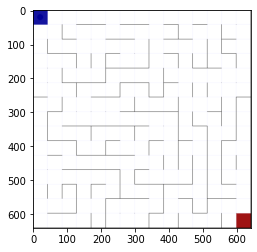

In [ ]:
env = MazeEnvSample15x15() 
env.reset()
plt.imshow(env.render('rgb_array'))
state_size = env.observation_space
a = env.action_space 
state = env.reset()
env.render()
action = env.action_space.sample()
observation, reward, done, info = env.step(action)
env.render()
print(f'action: {action}, observation: {observation},  reward: {reward}, done: {done}')


### Environment 30X30

iteration: 10, action: 0,  observation: [0 3], reward: -0.00011111111111111112, done: False


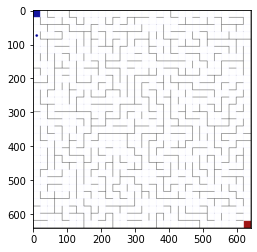

In [ ]:
env = MazeEnvSample30x30() 
env = wrap_env(env)
env.reset()
plt.imshow(env.render('rgb_array'))
done = False
iter = 0
print(done)
action = 1
while (iter < 10):#not done:
  iter +=1
  action = env.action_space.sample()
  observation, reward, done, _ = env.step(action)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  print(f'iteration: {iter}, action: {action},  observation: {observation}, reward: {reward}, done: {done}')

### Play video

In [ ]:
env.close()
show_video()